# Fashion Recommender System Using Resnet50 and NearestNeighbors

#                                 Game Plan

**Image Dataset:**
Start with a dataset containing 44,000 fashion images.
**Pre-trained Model - ResNet-50:**

Utilize the pre-trained ResNet-50 model, a convolutional neural network (CNN) trained on a large dataset for image classification tasks.

**Extracting Embeddings:**
Pass each image through the ResNet-50 model to extract feature embeddings.
The output will be a numerical vector (embedding) that represents the image's features

**Embedding Extraction Function:**
Define a function to extract embeddings using the pre-trained ResNet-50 model. This function takes an image as input and returns the corresponding feature embedding.

**Search for Similar Embeddings:**
When a new image is presented to the system:
Use the embedding extraction function to obtain the embedding for the new image.
Compare this embedding with the embeddings of all images in the dataset.

**Similarity Ranking:**
Calculate the similarity between the embeddings (e.g., cosine similarity).
Rank the images based on their similarity to the embedding of the new image.

**Top 5 Similar Images:**
Select the top 5 images with the highest similarity scores.

**Display Recommendations:**
Display the top 5 images as fashion recommendations for the given new image.

## Import Modules

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import GlobalMaxPooling2D
from sklearn.neighbors import NearestNeighbors
from numpy.linalg import norm
from tqdm.notebook import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Model

In [2]:
model = ResNet50(weights='imagenet', include_top = False, input_shape=(224, 224, 3))
model.trainable = False

model = tensorflow.keras.Sequential([
    model, 
    GlobalMaxPooling2D()
])

94765736/94765736 [==============================] - 0s 0us/step


In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_max_pooling2d (Glob  (None, 2048)              0         
 alMaxPooling2D)                                                 
                                                                 
Total params: 23587712 (89.98 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


# Feature Extract

In [4]:
img_path = '/kaggle/input/fashion-product-images-small/images'

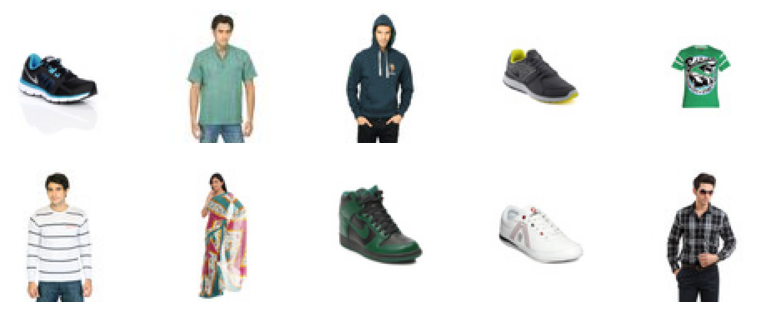

In [24]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_dir = '/kaggle/input/fashion-product-images-small/images'
img_paths = [os.path.join(img_dir, img_file) for img_file in os.listdir(img_dir)]

plt.figure(1, figsize=(10, 10))

for i in range(10):
    img = mpimg.imread(img_paths[i])
    plt.subplot(5, 5, i+1)
    plt.imshow(img)
    plt.axis('off')

plt.show()


In [7]:
def extract_features(imge_path, model):
    img = image.load_img(imge_path, target_size=(224,224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    result = model.predict(preprocessed_img,verbose=0).flatten()
    normalized_result = result / norm(result)
    
    return normalized_result

In [8]:
import pickle
filenames = []
for file in os.listdir(img_path):
    filenames.append(os.path.join(img_path, file))
    
feature_list = []
for file in tqdm(filenames):
    feature_list.append(extract_features(file, model))
    


  0%|          | 0/44441 [00:00<?, ?it/s]

ValueError: invalid mode: 'wp'

In [9]:
pickle.dump(feature_list, open('embedding.pkl','wb'))
pickle.dump(filenames,open('filenames.pkl', 'wb'))
pickle.dump(model, open('model.pkl', 'wb'))

# Test Result

In [12]:
feature_list = np.array(pickle.load(open('embedding.pkl', 'rb')))
filenames = pickle.load(open('filenames.pkl', 'rb'))
smodel = pickle.load(open('model.pkl', 'rb'))


# sample image
img = image.load_img('/kaggle/input/fashion-product-images-small/images/10022.jpg', target_size=(224,224)) # load image
img_array = image.img_to_array(img) # convert img to array
expanded_img_array = np.expand_dims(img_array, axis=0) # convert 2D array to 3D
preprocessed_img = preprocess_input(expanded_img_array) # preproccess the img as the resnet50 model required
result = smodel.predict(preprocessed_img).flatten() 
normalized_result = result / norm(result) # normalize the result

neighbors = NearestNeighbors(n_neighbors=6, algorithm='brute', metric='euclidean')
neighbors.fit(feature_list)
distances, indices = neighbors.kneighbors([normalized_result])
print(indices)

1/1 [==============================] - 1s 1s/step
[[ 1551 32476 32888 32955 32921 31289]]


# Show Recommended Photos

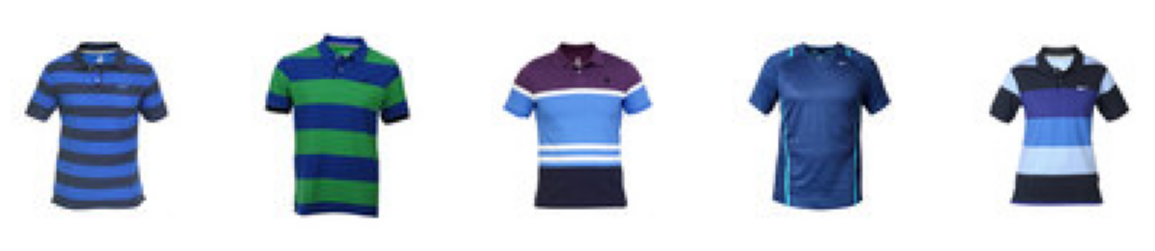

In [17]:
import cv2
import matplotlib.pyplot as plt

# Assuming 'indices' is a variable you have defined earlier
fig, axes = plt.subplots(1, 5, figsize=(15, 3))  # 1 row, 5 columns for the top 5 similar images

for i, file in enumerate(indices[0][1:6]):
    temp_img = cv2.imread(filenames[file])
    temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)  # OpenCV reads images in BGR format, converting to RGB
    
    # Display each image in a subplot
    axes[i].imshow(temp_img)
    axes[i].axis('off')  # Turn off axis labels

plt.show()
